In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import gzip
import io
import datetime
import os
from sbmtm import sbmtm
import graph_tool.all as gt

from itertools import compress

stopword szűrés
document-ek megadása nélkül
plotok javítása szövegek feltüntetése - label-ek
documentek SBM-es csoportosítása:
    mi labeleink alapján
    a topicdist alapján a legjobb

### Source: https://github.com/martingerlach/hSBM_Topicmodel

## Now:

#### Workaround: filter messages for 10 selected keywords, then take only every 10. or 100. word. The result is a file with $2 \cdot 10^4$ or $2 \cdot 10^5$ tweets.


## Previous:

#### Read all the content of a zipped file into the memory:
    with io.TextIOWrapper( gzip.open(filename) ) as f:
        x = f.readlines() # read the whole file
CPU times: user 38.2 s, sys: 2.78 s, total: 41 s, Wall time: 41 s

<font color='red'>Problem: not enough memory for processing words into list</font>

#### Read with buffered reader and save immediately to list:
    texts = [] # empty list for all the texts
    i = 0
    acctime = 0
    with io.TextIOWrapper( io.BufferedReader(gzip.open(filename)) ) as f:
            for line in f: # read one line at a time from a compressed file
                t1 = datetime.datetime.now()
                texts.append( line.split() )
                if i % int(10**7) == 0 and i != 0:
                    print('status:', int(i/10**7), ', elapsed time:', 
                          np.round(acctime*0.001, 3), 's', ', time to finish:', 
                          np.round(acctime*(10**8-i)/(i+1)*0.001, 1), 's' ) # estimation: 100 million rows
                t2 = datetime.datetime.now()
                dt = (t2-t1).microseconds*0.001
                acctime = acctime + dt 
                i += 1
                
<font color='red'>Problem: 60 million messages in list consumes around 30 GB of memory</font>

## Setup: Load a corpus

### 1) We have a list of documents, each document contains a list of words.

### 2) We have a list of document titles (optional) 

In [2]:
%%time
data = pd.read_csv( '../Data/All_filtered.txt.gz', names=['Tweets', 'Targets'], 
                   compression='gzip', delimiter='\t' )

CPU times: user 362 ms, sys: 28 ms, total: 390 ms
Wall time: 389 ms


In [3]:
data.head()

,Tweets,Targets
0,aaaah final saw thor even better than expect w...,cinema
1,aaaahhh food benthanh street food market,market
2,aaa am so happi succeed in buy ticket to the c...,cinema
3,aaaand no question on climat or environ not su...,climate
4,aaaand on the job market too,market


In [4]:
tweets = data['Tweets'].values.tolist()
targets = data['Targets'].values.tolist()
tweets[0], targets[0]

('aaaah final saw thor even better than expect we laugh indec amount for finnish cinema ka raw you gem',
 'cinema')

In [5]:
%%time
texts = []
for i in range( len(tweets) ):
    texts.append( tweets[i].split() )

CPU times: user 434 ms, sys: 47.7 ms, total: 482 ms
Wall time: 480 ms


In [6]:
np.shape(texts), np.shape(targets)

((219941,), (219941,))

## Fitting the model

In [7]:
## we create an instance of the sbmtm-class
model = sbmtm()

In [8]:
%%time
## we have to create the word-document network from the corpus
#model.make_graph( texts, documents=targets, n_min=10 ) # n_min: filter all word-nodes with less than n_min counts

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


### We can also skip the previous step by saving/loading a graph
model.save_graph(filename = 'graph.xml.gz')

model.load_graph(filename = 'graph.xml.gz')


In [9]:
%%time
#model.save_graph( filename = 'graph_every100_merged_nmin_10.xml.gz' )
model.load_graph( filename = 'graph_every10_merged_nmin_10.xml.gz' )

CPU times: user 8.27 s, sys: 48.4 ms, total: 8.32 s
Wall time: 8.28 s


### Parameters of the graph
D: doc-nodes == number of documents

N: number of edges == tokens

V: number of word-nodes == types

In [10]:
model.get_D(), model.get_N(), model.get_V()

(10, 2798953, 10568)

In [11]:
model.documents

['cinema',
 'market',
 'climate',
 'election',
 'hungary',
 'terror',
 'concert',
 'nfl',
 'physics',
 'data_mining']

In [12]:
%%time
## fit the model
gt.seed_rng(32) ## seed for graph-tool's random number generator --> same results
model.fit()

CPU times: user 1h 52min 42s, sys: 12.3 s, total: 1h 52min 54s
Wall time: 1h 50min 30s


## Plotting the result

The output shows the (hierarchical) community structure in the word-document network as inferred by the stochastic block model:

- document-nodes are on the left
- word-nodes are on the right
- different colors correspond to the different groups

The result is a grouping of nodes into groups on multiple levels in the hierarchy:

- on the uppermost level, each node belongs to the same group (square in the middle)
- on the next-lower level, we split the network into two groups: the word-nodes and the document-nodes (blue sqaures to the left and right, respectively). This is a trivial structure due to the bipartite character of the network.
- only next lower levels constitute a non-trivial structure: We now further divide nodes into smaller groups (document-nodes into document-groups on the left and word-nodes into word-groups on the right)

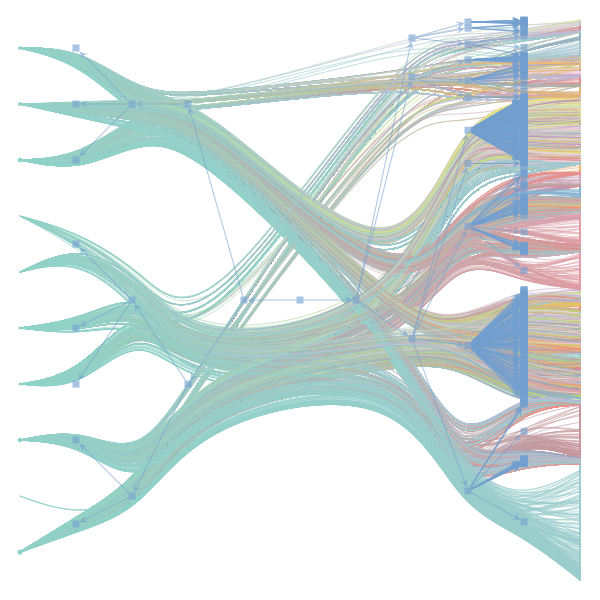

CPU times: user 11.4 s, sys: 12 ms, total: 11.4 s
Wall time: 9.24 s


In [31]:
%%time
model.plot(nedges=10000)

http://ryancompton.net/2014/10/22/stochastic-block-model-based-edge-bundles-in-graph-tool/

## The basics

### Topics
For each word-group on a given level in the hierarchy, we retrieve the $n$ most common words in each group -- these are the topics!

In [14]:
model.L

3

In [15]:
model.topics(l=0,n=10)

{0: [('final', 0.9629893238434164), ('goodby', 0.03701067615658363)],
 1: [('saw', 0.7696078431372549), ('alon', 0.23039215686274508)],
 2: [('cinema', 0.7058349215657528),
  ('cinemat', 0.08620436886087084),
  ('cinematographi', 0.05050579093974491),
  ('regal', 0.0499193666617798),
  ('cinemark', 0.026902213751649317),
  ('imax', 0.015980061574549186),
  ('rpx', 0.010848849142354493),
  ('cinematograph', 0.01055563700337194),
  ('gsc', 0.010409030933880663),
  ('thor', 0.007257000439818208)],
 3: [('still', 0.2113680956061597),
  ('even', 0.19810928117010523),
  ('could', 0.1414471728402402),
  ('everyon', 0.0872227837564659),
  ('actual', 0.08181223616148403),
  ('alreadi', 0.0749152743920566),
  ('ok', 0.04381948986265533),
  ('heard', 0.03834948570069564),
  ('told', 0.03644687555740531),
  ('sorri', 0.030263392591711756)],
 4: [('back', 0.4253131647364689),
  ('start', 0.3494445757504136),
  ('better', 0.22524225951311747)],
 5: [('has', 0.3028856679949205),
  ('than', 0.14209397

### Topic-distribution in each document
Which topics contribute to each document?

In [16]:
model.documents

['cinema',
 'market',
 'climate',
 'election',
 'hungary',
 'terror',
 'concert',
 'nfl',
 'physics',
 'data_mining']

In [68]:
## select a document (by its index)
i_doc = 0
print(model.documents[i_doc])
## get a list of tuples (topic-index, probability)
model.topicdist( i_doc, l=0 )

cinema


[(0, 0.0011449635566477701),
 (1, 0.0019129269178139573),
 (2, 0.09466195649138484),
 (3, 0.005480465804685973),
 (4, 0.002604093942863526),
 (5, 0.004956854422072663),
 (6, 0.00045379653159820157),
 (7, 0.0038049093803233826),
 (8, 0.007121114803541009),
 (9, 0.0041819095758049655),
 (10, 0.01612723058448993),
 (11, 0.02833784802703231),
 (12, 0.0003211483146694965),
 (13, 0.012217598927643888),
 (14, 0.006262392136055181),
 (15, 0.0005724817783238851),
 (16, 0.0005515373230193526),
 (17, 0.00024435197855287774),
 (18, 0.023702141919629143),
 (19, 0.011030746460387054),
 (20, 0.0010262783099220865),
 (21, 6.981485101510793e-05),
 (22, 0.030823256723170152),
 (23, 0.0013613895947946048),
 (24, 0.001689519394565612),
 (25, 0.04395543019911195),
 (26, 0.0025133346365438856),
 (27, 0.011631154179116981),
 (28, 0.000774944846267698),
 (29, 0.007665670641458851),
 (30, 0.0006213521740344606),
 (31, 0.011330950319752018),
 (32, 0.0),
 (33, 0.004482113435169929),
 (34, 6.981485101510793e-05),

In [18]:
def contribution_of_topics_in_a_doc( layer=0, i_doc=0, thr=20 ):
    # extract topics in layer 0
    topics = model.topics( l=layer, n=10 )

    # extract topic distribution for document numbered with i_doc
    topicdist = model.topicdist( doc_index=i_doc, l=layer )

    # reorder data
    topics_list = []
    for i in range( len(topics) ):
        topics_list.append( topics[i][0][0] )

    topicdist_list = []
    for i in range( len(topicdist) ):
        topicdist_list.append( topicdist[i][1] )
    
    # sorting
    filt_idx = sorted(range(len(topicdist_list)), key=topicdist_list.__getitem__)
    topics_list = [ topics_list[ filt_idx[::-1][i] ] for i in range( len(topics_list) ) ]
    topicdist_list = [ topicdist_list[ filt_idx[::-1][i] ] for i in range( len(topicdist_list) ) ]

    # apply threshold to keep only largest contributes (ex. first 15)
    
    # plotting
    fig = plt.figure( figsize=(8,2), dpi=100 )
    plt.title( 'Topic contribution in document \''+str(model.documents[i_doc])+'\'', fontsize=16)
    plt.xticks( np.arange(len(topicdist_list[:thr])), topics_list[:thr], rotation=90, fontsize=10)
    #plt.xlabel( 'Topics', fontsize = 15 )
    plt.ylabel( 'Frequency', fontsize = 12)
    #plt.scatter( np.arange(len(topicdist_list)), topicdist_list, s=15, marker='o' )
    plt.bar( np.arange(len(topicdist_list[:thr])), topicdist_list[:thr], width=0.8 )

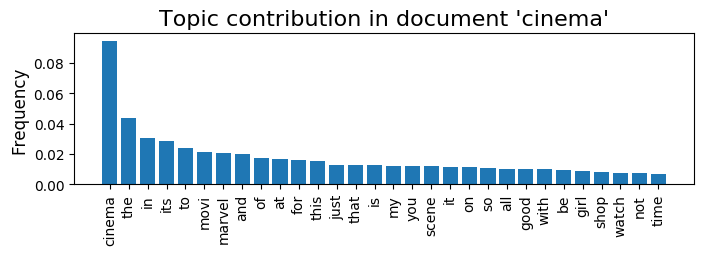

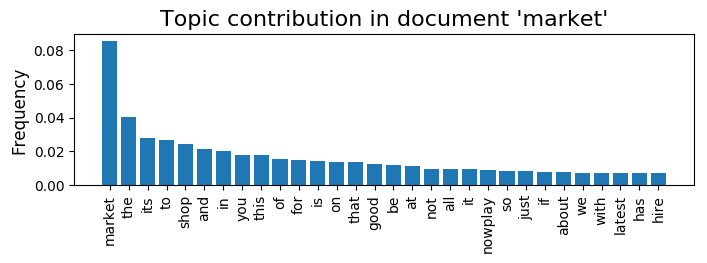

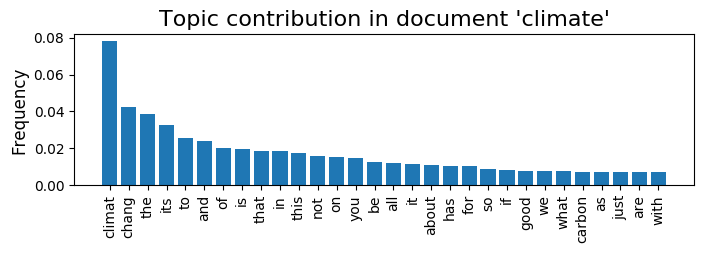

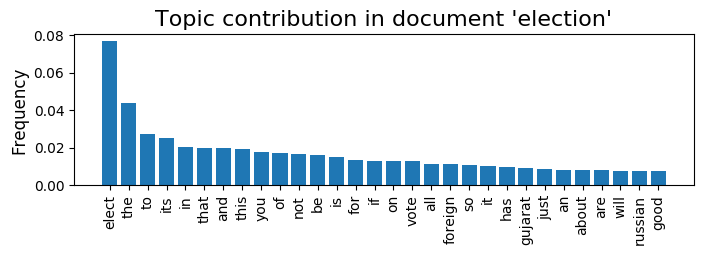

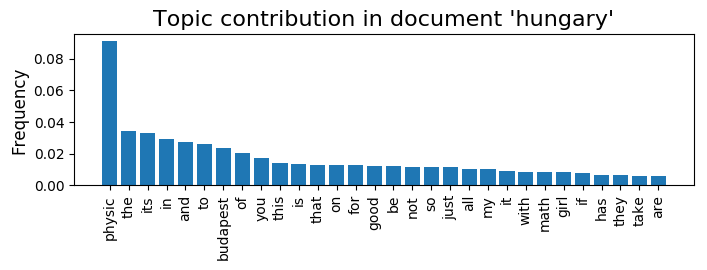

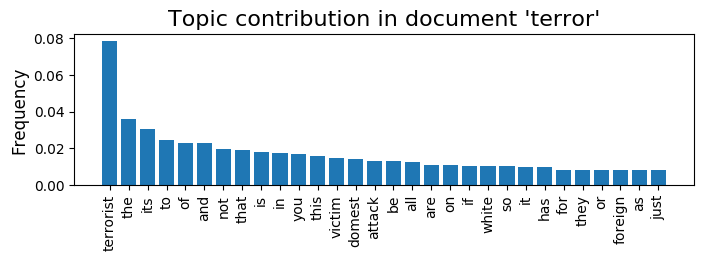

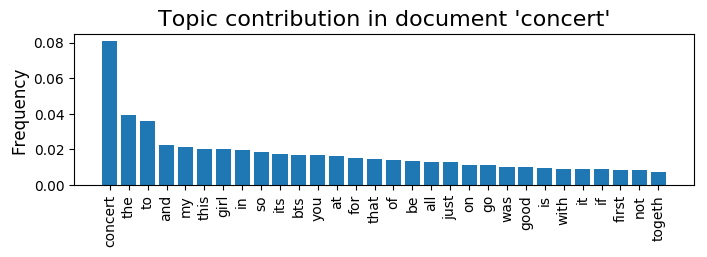

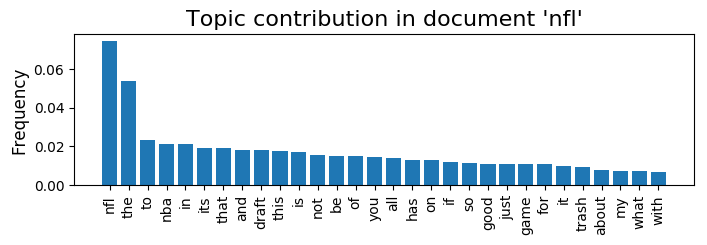

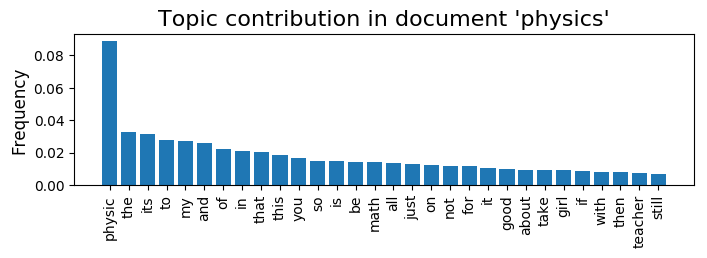

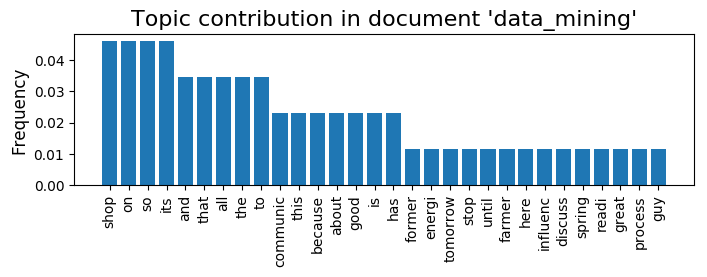

In [19]:
for i in range(model.get_D()):
    contribution_of_topics_in_a_doc( layer=0, i_doc=i, thr=30 )

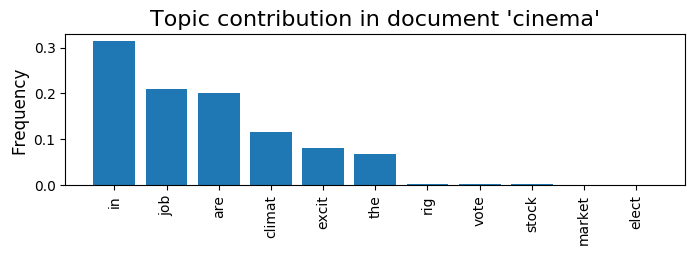

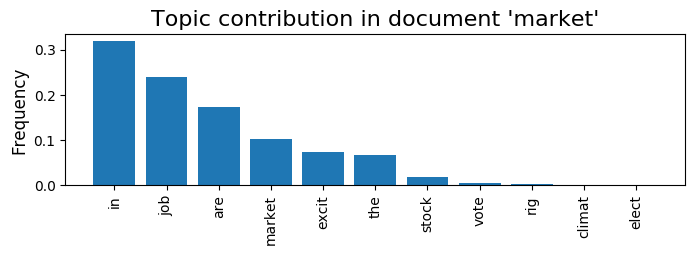

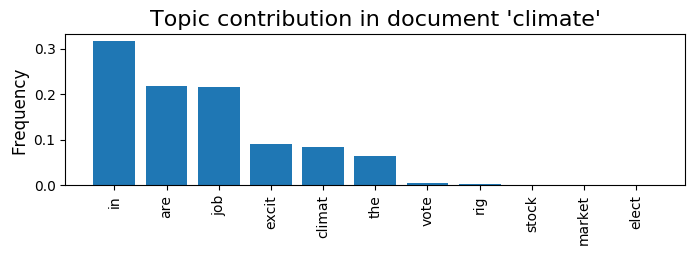

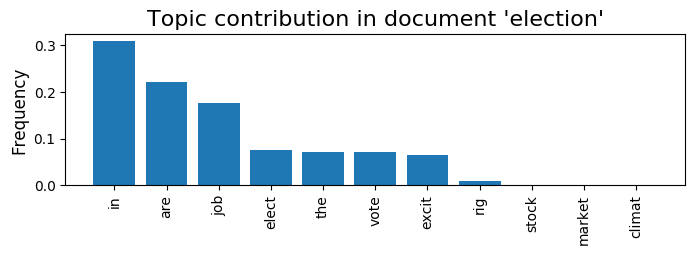

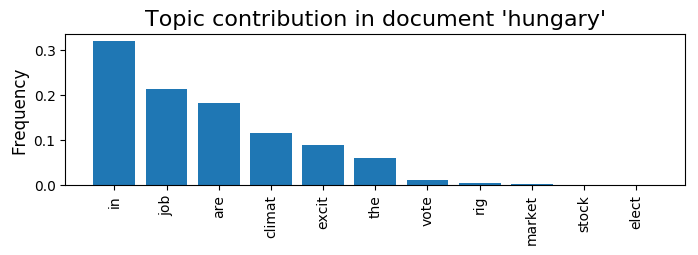

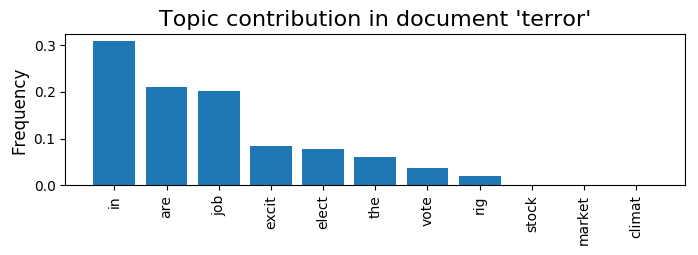

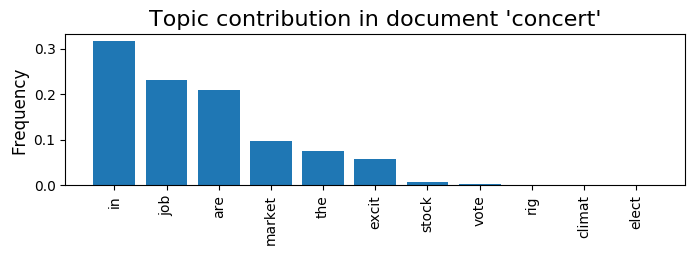

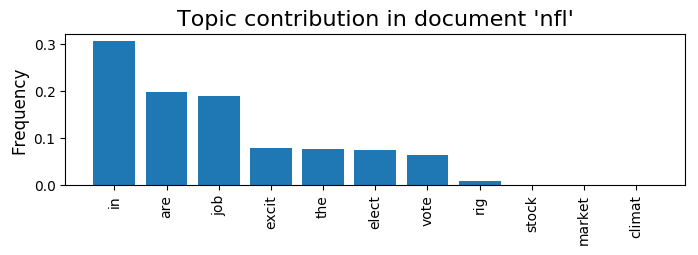

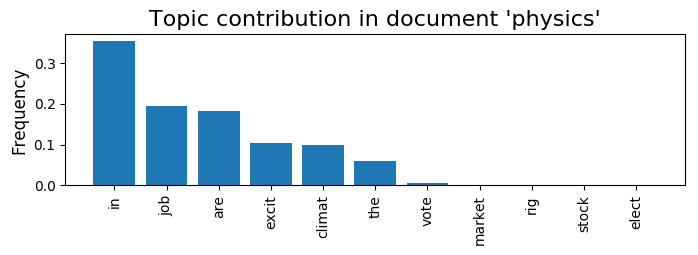

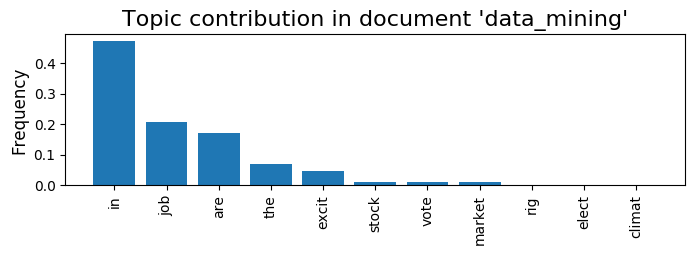

In [28]:
for i in range(model.get_D()):
    contribution_of_topics_in_a_doc( layer=1, i_doc=i, thr=30 )

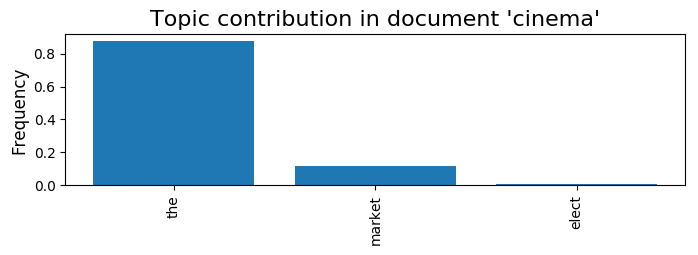

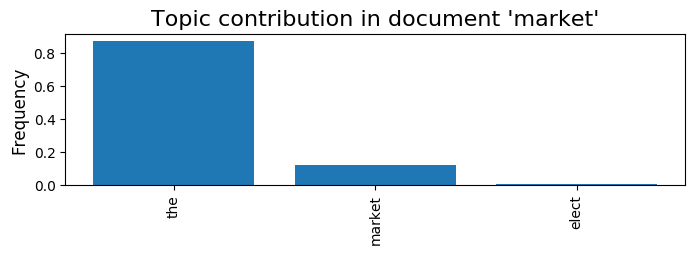

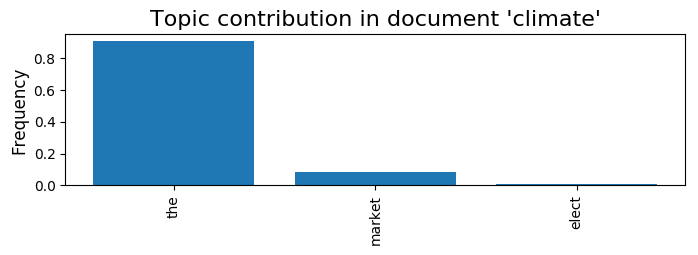

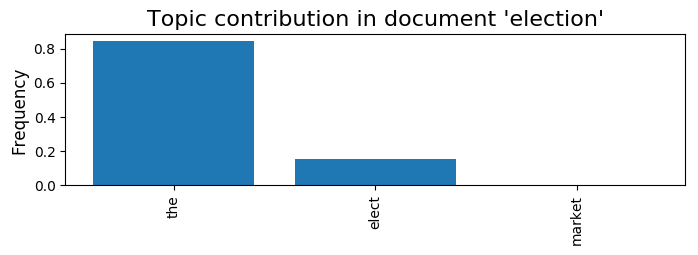

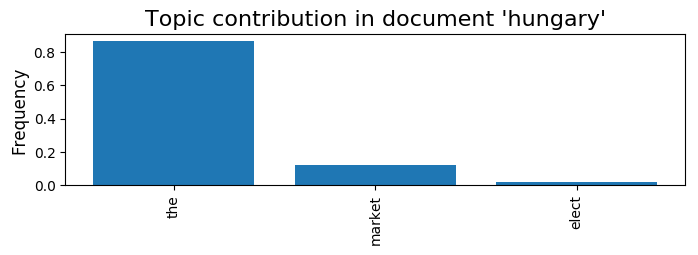

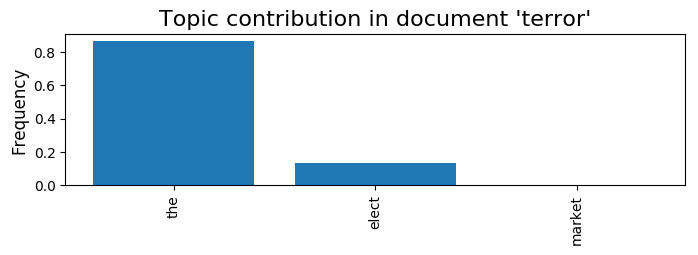

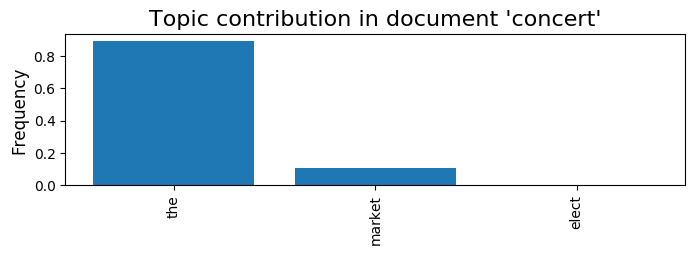

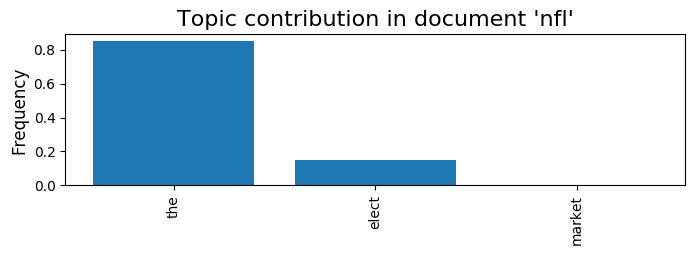

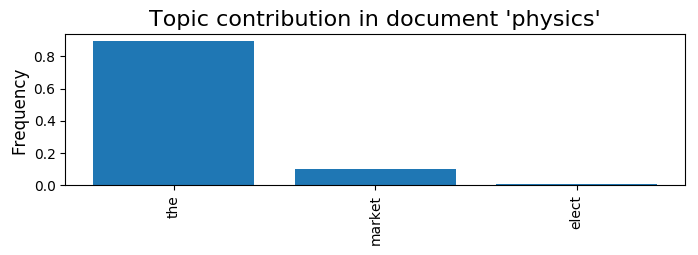

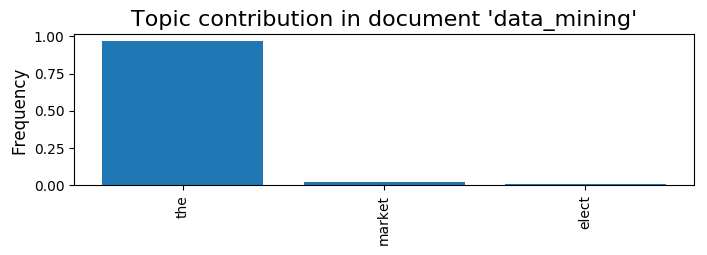

In [29]:
for i in range(model.get_D()):
    contribution_of_topics_in_a_doc( layer=2, i_doc=i, thr=30 )

## Extra: Clustering of documents - for free.
The stochastic block models clusters the documents into groups.
We do not need to run an additional clustering to obtain this grouping.

In [41]:
model.clusters(l=0,n=10)

{0: [('cinema', 1.0)],
 1: [('data_mining', 1.0), ('market', 1.0)],
 2: [('climate', 1.0)],
 3: [('election', 1.0)],
 4: [('physics', 1.0), ('hungary', 1.0)],
 5: [('terror', 1.0)],
 6: [('concert', 1.0)],
 7: [('nfl', 1.0)]}

In [42]:
model.clusters(l=1,n=10)

{0: [('physics', 1.0), ('hungary', 1.0), ('climate', 1.0), ('cinema', 1.0)],
 1: [('data_mining', 1.0), ('concert', 1.0), ('market', 1.0)],
 2: [('nfl', 1.0), ('terror', 1.0), ('election', 1.0)]}

In [43]:
model.clusters(l=2,n=10)

{0: [('data_mining', 1.0),
  ('physics', 1.0),
  ('concert', 1.0),
  ('hungary', 1.0),
  ('climate', 1.0),
  ('market', 1.0),
  ('cinema', 1.0)],
 1: [('nfl', 1.0), ('terror', 1.0), ('election', 1.0)]}

Application -- Finding similar articles:

For a query-article, we return all articles from the same group

In [66]:
for k in range( model.L ):
    print( 'Layer:', k ) 
    for i in range(model.get_D()):
        print( model.clusters_query( i, l=k ) )
    print('')

Layer: 0
[]
[(9, 'data_mining')]
[]
[]
[(8, 'physics')]
[]
[]
[]
[(4, 'hungary')]
[(1, 'market')]

Layer: 1
[(2, 'climate'), (4, 'hungary'), (8, 'physics')]
[(6, 'concert'), (9, 'data_mining')]
[(0, 'cinema'), (4, 'hungary'), (8, 'physics')]
[(5, 'terror'), (7, 'nfl')]
[(0, 'cinema'), (2, 'climate'), (8, 'physics')]
[(3, 'election'), (7, 'nfl')]
[(1, 'market'), (9, 'data_mining')]
[(3, 'election'), (5, 'terror')]
[(0, 'cinema'), (2, 'climate'), (4, 'hungary')]
[(1, 'market'), (6, 'concert')]

Layer: 2
[(1, 'market'), (2, 'climate'), (4, 'hungary'), (6, 'concert'), (8, 'physics'), (9, 'data_mining')]
[(0, 'cinema'), (2, 'climate'), (4, 'hungary'), (6, 'concert'), (8, 'physics'), (9, 'data_mining')]
[(0, 'cinema'), (1, 'market'), (4, 'hungary'), (6, 'concert'), (8, 'physics'), (9, 'data_mining')]
[(5, 'terror'), (7, 'nfl')]
[(0, 'cinema'), (1, 'market'), (2, 'climate'), (6, 'concert'), (8, 'physics'), (9, 'data_mining')]
[(3, 'election'), (7, 'nfl')]
[(0, 'cinema'), (1, 'market'), (2, 'c

In [64]:
model.clusters_query( 1, l=0 )

[(9, 'data_mining')]

In [36]:
## select a document (index)
i_doc = 0
#print('printed document (tweet):', i_doc, model.documents[i_doc])
print('Current tweet:', i_doc, texts[i_doc], '\n\nSimilar tweets:')
## find all articles from the same group
## print: (doc-index, doc-title)
tweets_similar = [ model.clusters_query( 1, l=0 ) ]

a = []
for i in tweets_similar[0]:
    a.append(i[0])
    
for i in a:
    print(i, texts[i])

Current tweet: 0 ['aaaah', 'final', 'saw', 'thor', 'even', 'better', 'than', 'expect', 'we', 'laugh', 'indec', 'amount', 'for', 'finnish', 'cinema', 'ka', 'raw', 'you', 'gem'] 

Similar tweets:
9 ['aaaannnd', 'russia', 'attack', 'our', 'elect', 'continu', 'to', 'do', 'that', 'threaten', 'us', 'with', 'nuclear', 'missil']


In [25]:
model.get_D(), model.get_N(), model.get_V()

(10, 2798953, 10568)

## More technical: Group membership
In the stochastic block model, word (-nodes) and document (-nodes) are clustered into different groups.

The group membership can be represented by the conditional probability $P(\text{group}\, |\, \text{node})$. Since words and documents belong to different groups (the word-document network is bipartite) we can show separately:

- P(bd | d), the probability of document $d$ to belong to document group $bd$
- P(bw | w), the probability of word $w$ to belong to word group $bw$.

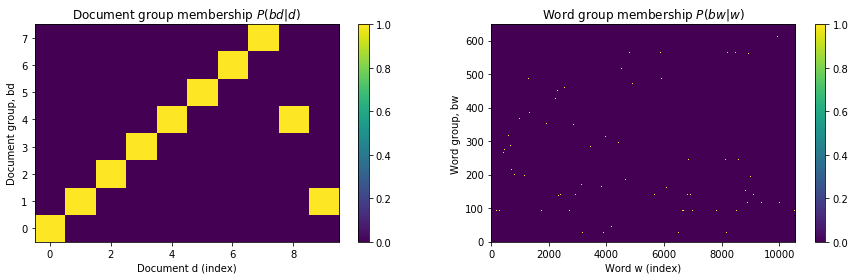

In [26]:
p_td_d,p_tw_w = model.group_membership(l=0)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.imshow(p_td_d,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Document group membership $P(bd | d)$')
plt.xlabel('Document d (index)')
plt.ylabel('Document group, bd')
plt.colorbar()

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()

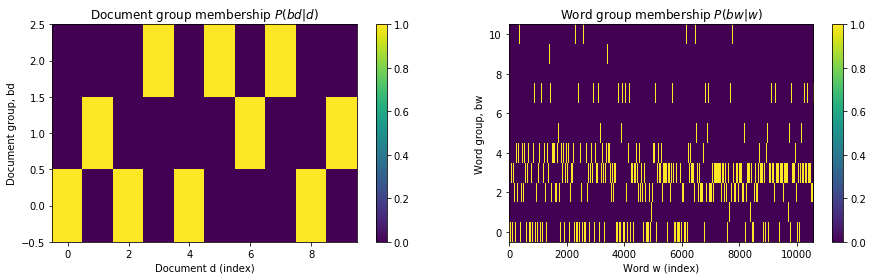

In [27]:
p_td_d,p_tw_w = model.group_membership(l=1)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.imshow(p_td_d,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Document group membership $P(bd | d)$')
plt.xlabel('Document d (index)')
plt.ylabel('Document group, bd')
plt.colorbar()

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()

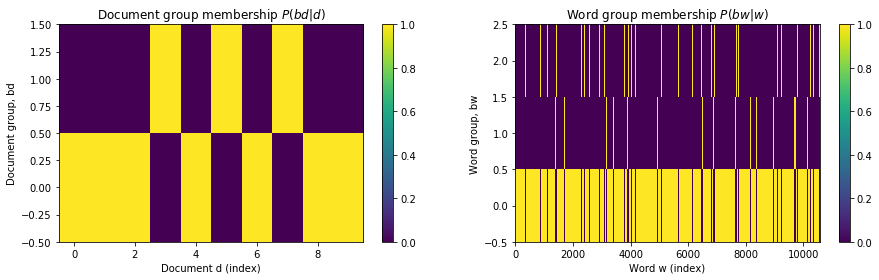

In [30]:
p_td_d,p_tw_w = model.group_membership(l=2)

plt.figure(figsize=(15,4))
plt.subplot(121)
plt.imshow(p_td_d,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Document group membership $P(bd | d)$')
plt.xlabel('Document d (index)')
plt.ylabel('Document group, bd')
plt.colorbar()

plt.subplot(122)
plt.imshow(p_tw_w,origin='lower',aspect='auto',interpolation='none')
plt.title(r'Word group membership $P(bw | w)$')
plt.xlabel('Word w (index)')
plt.ylabel('Word group, bw')
plt.colorbar()